##Description:

    Use DeSeq2 to identify differential abundance among treatments
    Following  Ashley's succ-C notebook


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import pandas as pd
import pandas.rpy.common as com
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import brewer2mpl
from mpltools import style
from IPython.display import FileLink
style.use("ggplot")
%matplotlib inline

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.8’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.2’
[1] "ggplot2"
[1] ‘1.0.1’
[1] "gridExtra"
[1] ‘0.9.1’
[1] "scales"
[1] ‘0.2.5’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.2’
[1] "tidyr"
[1] ‘0.2.0’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.0’


In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

NameError: name 'os' is not defined

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 16M
lrwxrwxrwx 1 bryan bryan 130 Jul 29 08:03 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan 143 Jul 29 08:03 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 16M Jul 28 12:47 bare-plant.csv


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



##apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [8]:
%%R
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

Remove controls and relevel factors so that bare is the reference level

In [9]:
%%R
#remove controls
physeq = subset_samples(physeq, !is.na(Plant))
#re-order levels 
sample_data(physeq)$Plant = relevel(sample_data(physeq)$Plant, "BARE")

##Filter samples
Initial run without filtering, consider filtering to test effects
 

##Create DeSeq2 object

In [37]:
%%R
library("BiocParallel")
register(MulticoreParam(6))

###Initial run is all plants, which will group bare soils into a single group

In [ ]:
%%R
#s = sample_data(physeq)
#s$Planted = factor(ifelse(s$Plant == "BARE", "BARE", "Rhizosphere"))
#sample_data(physeq) = s
#sample_data(physeq) %>% str()

In [ ]:
%%R
#p.dds = phyloseq_to_deseq2(physeq, ~Planted)
#p.dds = DESeq(p.dds, test = "Wald", fitType="parametric", parallel = TRUE)

In [ ]:
%%R
plotDispEsts(p.dds)

In [ ]:
%%R
sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP) 
sample_data(physeq)$DAP %>% levels

In [ ]:
%%R
res=results(p.dds, contrast=
                    c("Plant","HELAN", "BARE"), parallel = TRUE)
res

In [ ]:
%%R
#summary(res) %>% print
plotMA(res, main="DESeq2", ylim=c(-2,2))

#Function generating plant log2fold change figure

In [37]:
%%R


asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    theta = 0.5
    r = results(diagdds)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    return(r[, c("log2FoldChange", "p")])
}

deseq_prune = function(physeq.obj, plant, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("BARE", plant))&
                     (physeq.md$DAP == day), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
    return(p.thresh)
}

In [43]:
%%R -w 1200 -h 600
Sd = sample_data(physeq)

days = levels(Sd$DAP)
res.list = vector("list", length(days))
names(res.list) = as.character(days)
res.list

df_all = data.frame()

for (day in days) {
    print(day) ##need to remove
    Sd.d = Sd[Sd$DAP == day,]
    Sd.d = Sd.d[Sd.d$Plant != "BARE"]
    Plants = levels(Sd.d$Plant) 
    Plants %>% print
    
    res.list.list = NULL        
    res.list.list = vector("list", length(Plants))
    names(res.list) = Plants
    df_plant = data.frame()
    
    for (plant in Plants) {
        DF = NULL
        physeq.plant = deseq_prune(physeq, plant, day)
        #re-order levels 
        sample_data(physeq.plant)$Plant = relevel(sample_data(physeq.plant)$Plant, "BARE")
        DF = get_Ps(physeq.plant)
        supp = tax_table(physeq.plant)
        if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }    
        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Day = day
        df_plant = rbind(df_plant, DF)
    }
    df_plant$Plant = plant
    df_all = rbind(df_all, df_plant)
}
    

[1] "36"
[1] "FAGES"
converting counts to integer mode
[1] "53"
[1] "AMAPO" "ECHCG"
converting counts to integer mode
converting counts to integer mode
[1] "57"
[1] "ABUTH" "GLYMA"
converting counts to integer mode
converting counts to integer mode
[1] "61"
[1] "SETFA"
converting counts to integer mode
[1] "72"
[1] "75-062" "ERATE"  "H99"    "Il14H"  "MS71"  
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
[1] "79"
[1] "B73"   "B97"   "Hp301" "Oh7B" 
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
[1] "84"
[1] "HELAN"  "SORBI"  "SORSUD"
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
[1] "88"
[1] "ELCOR" "Ki3"   "Mo18"  "Tx303"
converting counts to integer mode
converting counts to integer mode
converting counts to integer mod

In [54]:
%%R -i workDir
df_all$p.adj = p.adjust(df_all$p, "BH")
setwd(workDir)
write.table(df_all, "bare-plant.csv", row.names = FALSE, sep = ",")

#Checkpoint, read file of bare-plant.csv to continue

In [8]:
%%R -i workDir
setwd(workDir)
df_all = read.csv("bare-plant.csv", header = TRUE)
head(df_all)

  log2FoldChange         p    Rank1         Rank2      Rank3
1     -1.2367952 0.9546068 Bacteria Acidobacteria      32-21
2     -0.9585578 0.9991682 Bacteria Acidobacteria Holophagae
3      1.2749069 0.1830659 Bacteria Acidobacteria Holophagae
4     -0.9888109 0.9999998 Bacteria Acidobacteria Holophagae
5     -0.6785618 0.9673205 Bacteria Acidobacteria Holophagae
6     -3.2346654 0.9988116 Bacteria Acidobacteria     BPC102
                 Rank4                Rank5 Rank6 Rank7 Rank8      OTU Day
1 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> OTU.5899  36
2              Sva0725                 <NA>  <NA>  <NA>  <NA> OTU.8680  36
3              Sva0725 uncultured_bacterium  <NA>  <NA>  <NA> OTU.2666  36
4              Sva0725                 <NA>  <NA>  <NA>  <NA>  OTU.323  36
5              Sva0725                 <NA>  <NA>  <NA>  <NA> OTU.7636  36
6 uncultured_bacterium                 <NA>  <NA>  <NA>  <NA> OTU.3772  36
  Plant     p.adj
1 FAGES 1.0000000
2 FAGES 1.00

In [12]:
%%R
2

[1] 2


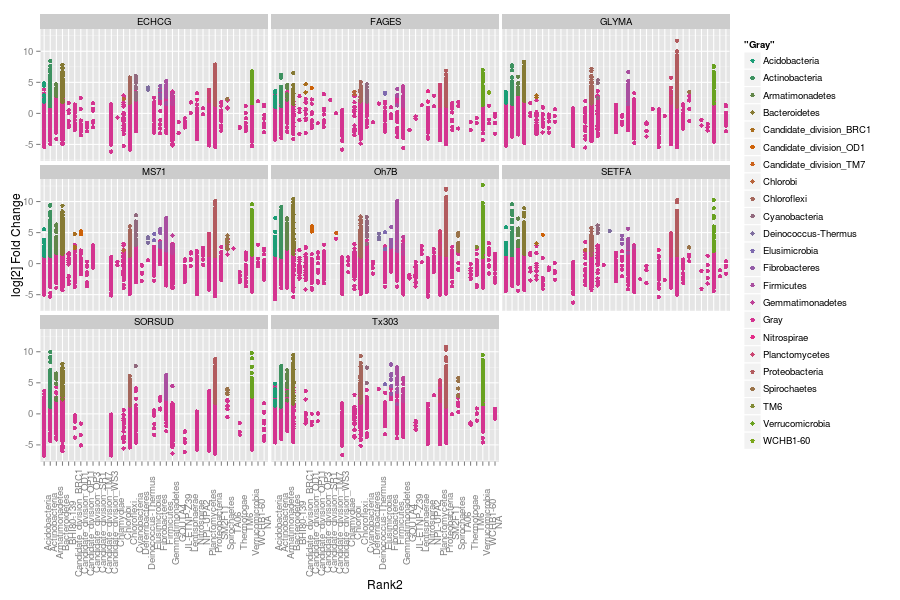

In [23]:
%%R -w 900 -h 600

colourCount = length(unique(df_all$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

df.sig = df_all[df_all$p.adj < .05,]
df.ns = df_all[df_all$p.adj >= .05,]

p = ggplot(df_all)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Plant)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p    
    

##Test for log2Fold change between plants with significant or non-significant increase in LAP

###Define enzyme significance variable, subset phyloseq object to 0N and join

In [48]:
%%R
#Create table with enzyme rhizosphere effect encoding
P = c("FAGES", "AMAPO", "ECHCG", "ABUTH","GLYMA", "SETFA", "75-062", "ERATE", "H99", "Il14H", "MS71",
      "B73", "B97", "Hp301", "Oh7B", "HELAN", "SORBI", "SORSUD", "ELCOR", "Ki3", "Mo18", "Tx303")
E.s = c(1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1)

E.re = data.frame(P,E.s)
E.re

        P E.s
1   FAGES   1
2   AMAPO   1
3   ECHCG   0
4   ABUTH   0
5   GLYMA   0
6   SETFA   1
7  75-062   0
8   ERATE   0
9     H99   0
10  Il14H   0
11   MS71   0
12    B73   0
13    B97   0
14  Hp301   0
15   Oh7B   1
16  HELAN   1
17  SORBI   1
18 SORSUD   1
19  ELCOR   1
20    Ki3   1
21   Mo18   0
22  Tx303   1


In [52]:
%%R
#subset phyloseq object to just unfertilized plots
physeq.plant = subset_samples(physeq, Plant != "BARE")
physeq.p.0N = subset_samples(physeq.plant, Treatment == "Nneg")
physeq.p.0N

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


In [53]:
%%R
#join enzyme factor to 
s.df = sample_data(physeq.p.0N)
s.df.e = left_join(s.df, E.re, by = c("Plant" = "P"))

s.df.e$E.s = factor(s.df.e$E.s)
s.df.e$E.s = gsub("1", "sig", s.df.e$E.s)
s.df.e$E.s = gsub("0", "ns", s.df.e$E.s)
s.df.e[,c("Plant","E.s")]
rownames(s.df.e) = s.df.e$X.sample

sample_data(physeq.p.0N) = s.df.e
sample_data(physeq.p.0N)$E.s = factor(sample_data(physeq.p.0N)$E.s)

'data.frame':	88 obs. of  22 variables:
Formal class 'sample_data' [package "phyloseq"] with 4 slots
  ..@ .Data    :List of 22
  .. ..$ : Factor w/ 88 levels "sample1-1.27_Nneg",..: 27 22 24 34 30 2 52 56 36 7 ...
  .. ..$ : int  1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ : int  1 1 1 1 2 1 2 2 2 1 ...
  .. ..$ : Factor w/ 53 levels "A1","A10","A11",..: 7 19 45 20 15 15 23 36 28 23 ...
  .. ..$ : int  25 19 23 27 3 3 51 53 5 51 ...
  .. ..$ : int  25 19 23 27 99 3 147 149 101 51 ...
  .. ..$ : int  25 19 23 27 99 3 147 149 101 51 ...
  .. ..$ : Factor w/ 88 levels "1.03_Nneg","1.04_Nneg",..: 16 23 83 43 25 39 41 58 55 27 ...
  .. ..$ : Factor w/ 22 levels "75-062","ABUTH",..: 1 19 19 1 17 9 4 4 17 3 ...
  .. ..$ : num  1.22 2.02 4.21 2.29 2.06 2.23 2.26 3.18 3.13 2.08 ...
  .. ..$ : Factor w/ 1 level "Nneg": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ : int  1 2 4 2 2 2 2 3 3 2 ...
  .. ..$ : int  72 61 61 72 72 36 79 79 72 53 ...
  .. ..$ : Factor w/ 8 levels "sample1","sample2",..: 5 4 4 5 5 1 6 6 5 2 .

###Generate DESeq object testing Enzyme significance 

In [54]:
%%R
p.dds = phyloseq_to_deseq2(physeq.p.0N, ~E.s)
p.dds = DESeq(p.dds, test = "Wald", fitType="parametric", parallel = TRUE)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 6 workers
mean-dispersion relationship
final dispersion estimates, MLE betas: 6 workers
fitting model and testing: 6 workers
-- replacing outliers and refitting for 274 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [71]:
%%R
res = results(p.dds, cooksCutoff = FALSE)
alpha = 0.05
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(physeq.p.0N)[rownames(sigtab), ], "matrix"))
sigtab

             baseMean log2FoldChange     lfcSE      stat       pvalue
OTU.1687    6.0066021     -0.8250315 0.2556059 -3.227749 1.247686e-03
OTU.9126    2.2079591      1.0675347 0.3140099  3.399685 6.746363e-04
OTU.10951   2.2752919     -0.9997625 0.3108944 -3.215762 1.300985e-03
OTU.983     2.8866524     -0.9881422 0.2755429 -3.586164 3.355777e-04
OTU.61     23.1745333     -0.6661475 0.1873201 -3.556198 3.762603e-04
OTU.577     2.7574852     -0.9471731 0.2912622 -3.251960 1.146123e-03
OTU.5442    1.2556075     -1.8237748 0.4436288 -4.111038 3.938846e-05
OTU.5401    0.8872441      1.1454336 0.3556746  3.220454 1.279879e-03
OTU.3114    8.1467157     -1.1343799 0.3288772 -3.449250 5.621457e-04
OTU.113     7.5558939     -0.9248333 0.2351530 -3.932901 8.392676e-05
OTU.593     3.2745283     -0.9174990 0.2583178 -3.551823 3.825727e-04
OTU.11563   0.7861542     -1.7496341 0.4179173 -4.186556 2.832196e-05
OTU.432     7.3793413     -1.0075200 0.2586513 -3.895284 9.808391e-05
OTU.990     1.112544

In [72]:
%%R
head(res)

log2 fold change (MAP): E.s sig vs ns 
Wald test p-value: E.s sig vs ns 
DataFrame with 6 rows and 6 columns
             baseMean log2FoldChange     lfcSE        stat     pvalue      padj
            <numeric>      <numeric> <numeric>   <numeric>  <numeric> <numeric>
OTU.5899  0.196153622   -0.153326314 0.4949970 -0.30975198 0.75674957        NA
OTU.11339 0.000000000             NA        NA          NA         NA        NA
OTU.11867 0.008960009   -0.006699161 0.2994993 -0.02236787 0.98215451        NA
OTU.12445 0.000000000             NA        NA          NA         NA        NA
OTU.8680  2.601542218   -0.700812027 0.2811857 -2.49234570 0.01269025 0.1363871
OTU.2666  0.620605884   -0.178822977 0.3837618 -0.46597389 0.64123419 0.8425452


In [ ]:
###Graph of taxa with significant log2fold change

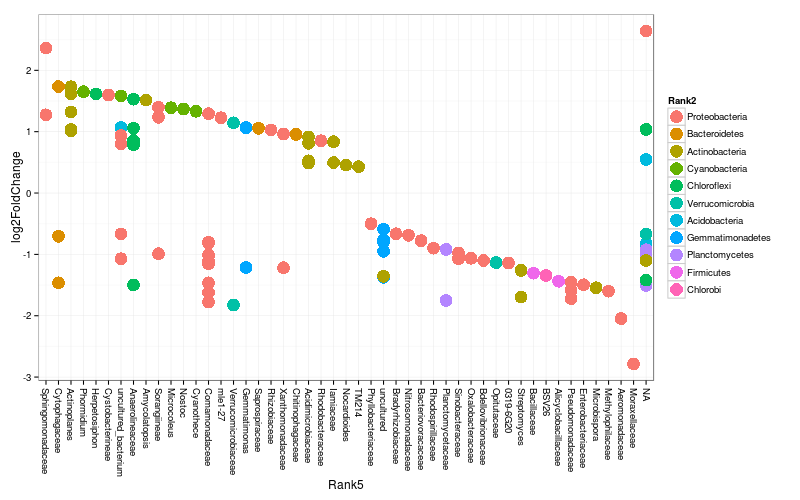

In [75]:
%%R -w 800 -h 500
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

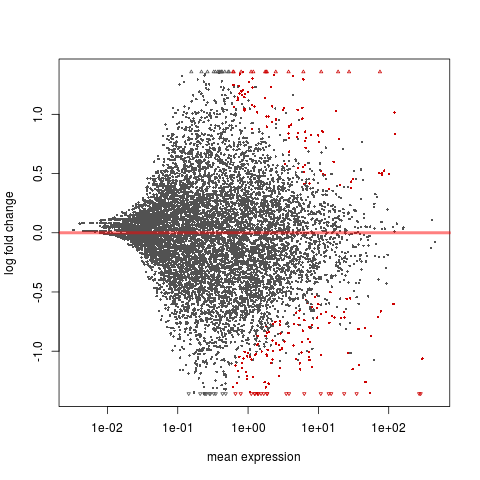

In [70]:
%%R
DESeq2::plotMA(res)